In [ ]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 34.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem
from rdkit.DataStructs import cDataStructs
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

#**Upload Bioactivity data (pIC50) of molecules (smiles)**

In [ ]:

df = pd.read_csv('Bioactivity_Data_clean.csv')
df

,Smiles,pIC50
0,COc1ccc2c(c1)OC[C@]1(O)c3cc4c(cc3O[C@H]21)OCO4,2.301030
1,COc1cc(O)c(/C=C\C(C)(C)O)c2c1C(=O)C[C@@H](c1cc...,2.455932
2,C=C1CC[C@@H](O)[C@]2(C)CC[C@@](O)(C(C)C)[C@H](...,2.552842
3,Oc1ccc(C2=COc3cc(O)ccc3C2)cc1,3.000000
4,Oc1ccc(C2=COc3cc(O)ccc3C2)cc1,3.000000
...,...,...
3069,Oc1ccc2c(c1)OCc1c-2nc2ccc(O)cc2c1-c1cccc(Cl)c1,6.841638
3070,COc1cc(/C=C2\SC(=O)NC2=O)ccc1Oc1ccc(C(F)(F)F)c...,6.853872
3071,CCOC(=O)C(Cc1ccc(C#CCCCC[C@@H]2Cc3cc(O)ccc3[C@...,6.898253
3072,CC(=O)c1ccc(Oc2ccc(O)c(C(C)(C)C)c2)c(Cl)c1,6.920819


In [ ]:
df = df.dropna ()
df

,Smiles,pIC50
0,COc1ccc2c(c1)OC[C@]1(O)c3cc4c(cc3O[C@H]21)OCO4,2.301030
1,COc1cc(O)c(/C=C\C(C)(C)O)c2c1C(=O)C[C@@H](c1cc...,2.455932
2,C=C1CC[C@@H](O)[C@]2(C)CC[C@@](O)(C(C)C)[C@H](...,2.552842
3,Oc1ccc(C2=COc3cc(O)ccc3C2)cc1,3.000000
4,Oc1ccc(C2=COc3cc(O)ccc3C2)cc1,3.000000
...,...,...
3069,Oc1ccc2c(c1)OCc1c-2nc2ccc(O)cc2c1-c1cccc(Cl)c1,6.841638
3070,COc1cc(/C=C2\SC(=O)NC2=O)ccc1Oc1ccc(C(F)(F)F)c...,6.853872
3071,CCOC(=O)C(Cc1ccc(C#CCCCC[C@@H]2Cc3cc(O)ccc3[C@...,6.898253
3072,CC(=O)c1ccc(Oc2ccc(O)c(C(C)(C)C)c2)c(Cl)c1,6.920819


#**FingerPrint & 2D Descriptors**

In [ ]:
descriptors = []
for i, row in df.iterrows():
    m = Chem.MolFromSmiles(str(row["Smiles"]))
    desc = []

    # calculate hashed atom pair fingerprint
    fp = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(m)
    desc.extend([int(x) for x in fp.ToBitString()])

    # calculate RDK fingerprint
    fp = Chem.RDKFingerprint(m)
    desc.extend(fp)

    # calculate additional molecular descriptors
    desc.append(Descriptors.MolWt(m))
    desc.append(Descriptors.MolLogP(m))
    desc.append(rdMolDescriptors.CalcNumHBA(m))
    desc.append(rdMolDescriptors.CalcNumHBD(m))
    desc.append(Descriptors.TPSA(m))
    desc.append(rdMolDescriptors.CalcFractionCSP3(m))
    desc.append(rdMolDescriptors.CalcNumRotatableBonds(m))
    desc.append(rdMolDescriptors.CalcNumAromaticRings(m))
    desc.append(rdMolDescriptors.CalcNumHeterocycles(m))

    descriptors.append(desc)


In [ ]:
# Convert the descriptors list to a Pandas dataframe
df2 = pd.DataFrame(descriptors)
df2.to_csv('decriptors.csv', index=False)
df2

,0,1,2,3,4,5,6,7,8,9,...,4095,4096,4097,4098,4099,4100,4101,4102,4103,4104
0,0,0,0,0,0,0,0,0,0,0,...,1,314.293,2.1376,6,1,66.38,0.294118,1,2,3
1,1,0,0,0,0,0,0,0,0,0,...,1,354.402,3.8914,5,2,75.99,0.285714,4,2,1
2,0,0,0,0,0,0,0,0,0,0,...,0,254.370,1.8616,3,3,60.69,0.866667,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,240.258,3.0738,3,2,49.69,0.066667,1,2,1
4,0,0,0,0,0,0,0,0,0,0,...,1,240.258,3.0738,3,2,49.69,0.066667,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3069,1,1,0,0,0,0,0,0,0,0,...,0,375.811,5.5258,4,2,62.58,0.045455,1,4,2
3070,0,0,0,0,0,0,0,0,1,0,...,1,474.254,5.5927,5,1,64.63,0.111111,4,2,1
3071,1,1,1,1,1,1,1,1,1,1,...,0,600.796,6.7323,6,2,93.06,0.578947,10,2,0
3072,0,0,0,0,0,0,0,0,0,0,...,1,318.800,5.3380,3,1,46.53,0.277778,3,2,0


In [ ]:
X = df2
y = df["pIC50"]

#**Split data into training and test sets**

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


# **QSAR Modell RandomForestRegressor**

In [ ]:
# train QSAR model
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

RandomForestRegressor(random_state=42)

In [ ]:
# predict bioactivity on test set
y_pred = model.predict(X)

In [ ]:
# evaluate model performance
print("R^2:", model.score(X_test, y_test))

R^2: 0.9338751662832239


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

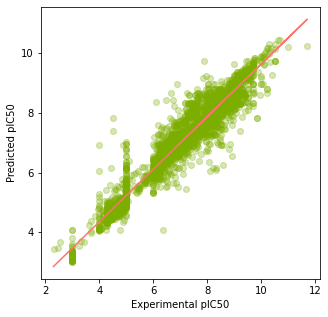

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(x=y, y=y_pred, c="#7CAE00", alpha=0.3)

z = np.polyfit(y, y_pred, 1)
p = np.poly1d(z)

plt.plot(y,p(y),"#F8766D")
plt.ylabel('Predicted pIC50')
plt.xlabel('Experimental pIC50')
plt.savefig('regression_curve.pdf')

#**Define a function to calculate the descriptors of a new molecule and Predict pIC50**

In [ ]:
def predict_bioactivity(smiles):
    m = Chem.MolFromSmiles(smiles)
    desc = []
    
    # calculate hashed atom pair fingerprint
    fp = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(m)
    desc.extend([int(x) for x in fp.ToBitString()])

    # calculate RDK fingerprint
    fp = Chem.RDKFingerprint(m)
    desc.extend(fp)

    # calculate additional molecular descriptors
    desc.append(Descriptors.MolWt(m))
    desc.append(Descriptors.MolLogP(m))
    desc.append(rdMolDescriptors.CalcNumHBA(m))
    desc.append(rdMolDescriptors.CalcNumHBD(m))
    desc.append(Descriptors.TPSA(m))
    desc.append(rdMolDescriptors.CalcFractionCSP3(m))
    desc.append(rdMolDescriptors.CalcNumRotatableBonds(m))
    desc.append(rdMolDescriptors.CalcNumAromaticRings(m))
    desc.append(rdMolDescriptors.CalcNumHeterocycles(m))

    descriptors.append(desc)
    return desc

# predict bioactivity of new molecule (Campesterol)
smiles = "CCC(=C(C1=CC=C(C=C1)O)C2=CC=C(C=C2)OCCN(C)C)C3=CC=CC=C3"
X_new = np.array(predict_bioactivity(smiles)).reshape(1, -1)

# Print the selected features
#print(selected_features)
bioactivity = model.predict(X_new)
print("Predicted bioactivity:", bioactivity)

Predicted bioactivity: [8.31563077]


#**Convert pIC50 to IC50 (nm)**

In [ ]:
pIC50 = bioactivity
IC50 = (10**-pIC50)*(10**9)
print("IC50:", IC50, "nM")

IC50: [4.83469669] nM
